# Anki review log

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 
sns.set_theme(style="darkgrid")

In [2]:
df = pd.read_csv('revlog.csv')

In [3]:
df

,id,cid,usn,ease,ivl,lastIvl,factor,time,type
0,1290193427570,1289966240018,769,3,0,0,2220,3209,0
1,1290892345787,1289966240018,769,4,12,0,2220,13050,2
2,1292053844424,1289966240018,769,4,36,12,2320,3757,1
3,1295323533496,1289966240018,769,3,83,36,2320,3182,1
4,1302625967217,1289966240018,769,4,251,83,2420,3249,1
...,...,...,...,...,...,...,...,...,...
134152,1686135419000,1684716863930,1827,3,3,-259200,2500,14000,0
134153,1686135420000,1684716441874,1827,3,3,-259200,2500,1000,0
134154,1686135423000,1684715113899,1827,3,3,-259200,2500,3000,0
134155,1686135431000,1684717642474,1827,3,3,-259200,2500,8000,0


Pretty important dataframe to calculate is the current settings on a card. To do this: 
- id contains date info as unix epoch time (# milliseconds passed since midnight UTC on jan 1, 1970)
- essentiall can iterate where each cid, get the max row of id and add

In [4]:
df_curr = df.groupby('cid').agg('max')
df_curr

,id,usn,ease,ivl,lastIvl,factor,time,type
cid,,,,,,,,
1287867332874,1622576986025,35,1,-60,-60,2500,10091,0
1287867617783,1622537685584,35,3,1,-60,2500,7803,0
1289966240018,1302625967217,769,4,251,83,2420,13050,2
1321299135325,1646715174154,410,3,1,-60,2500,8654,0
1321299135326,1646715176654,410,3,1,-60,2500,2498,0
...,...,...,...,...,...,...,...,...
1685598702394,1685876168000,1819,3,-86400,-300,0,12000,0
1685598702400,1685955415000,1820,3,-86400,-300,0,5000,0
1685599006378,1685955399000,1820,3,-86400,-300,0,80000,0


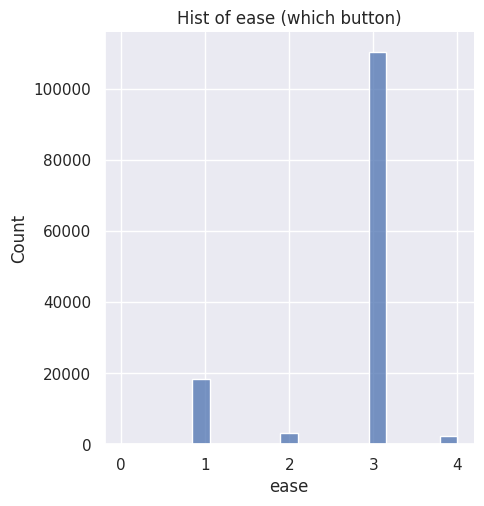

In [5]:
ax = sns.displot(df, x='ease').set(title='Hist of ease (which button)') 

This makes sense. I try not to use anything with strange adjustments on ease. The ratio of again to ok isn't great though

## Intervals - df.ivl

Positive values are in days

Negative values are in seconds (learning)


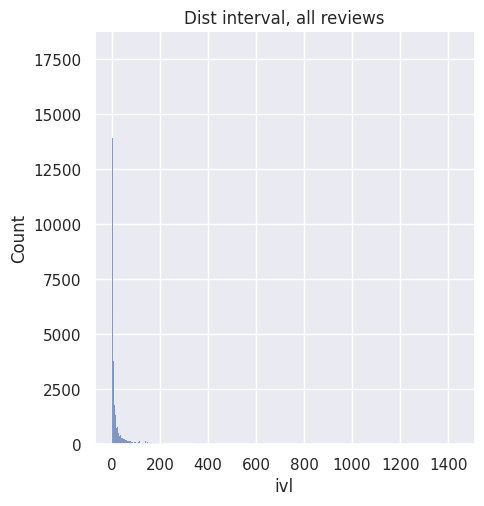

In [6]:
sns.displot(df[(df.ivl > 0)], x='ivl').set(title='Dist interval, all reviews') 

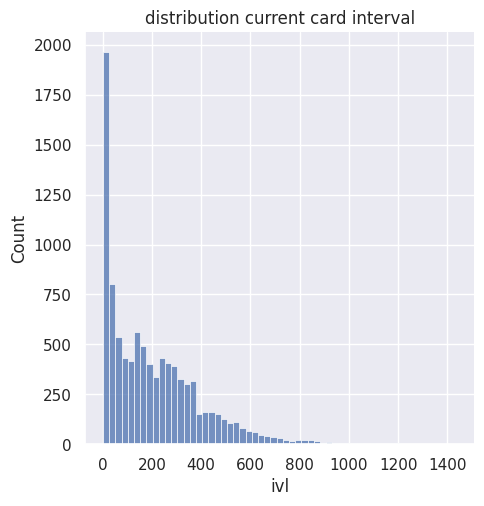

In [7]:
sns.displot(df_curr[(df_curr.ivl > 0)], x='ivl').set(title='distribution current card interval') 

About half of the cards have < 200 day interval. 

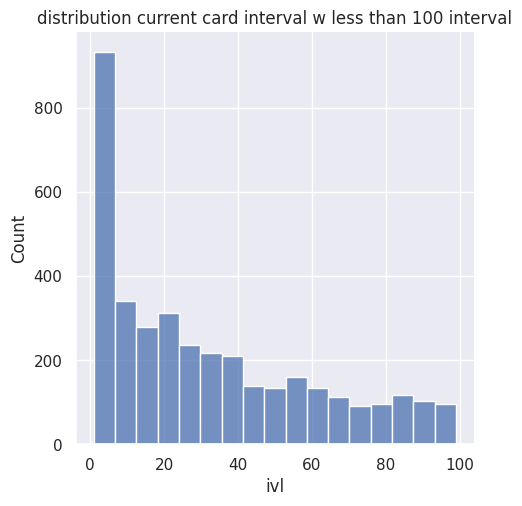

In [8]:
sns.displot(df_curr[(df_curr.ivl > 0) & (df_curr.ivl < 100)], x='ivl').set(title='distribution current card interval w less than 100 interval') 

# Questions.

- How long am I spending on anki 
- What proportion of the cards takes up % of my time.... is there a small subset which is very costly 
- What do the learning patterns looks like? 
    - Quantiled.
    - Distribution of fails to learn. 
    - Even just distribution of # of reviews of a card 
- Distribution of cumulative time per card. 

I remove anything above 1min review on card. I would never spend that time on a card 

In [10]:
import numpy as np

Looking at time which is measured in milliseconds, i'll convert to minutes

This shows us next to nothing. 

In [11]:
# just dropping the 1% quantile, probably left anki running in background 
q = np.quantile(df.time, 0.97) 
print(f"97th quantile is = {q / 60000}min")

97th quantile is = 1.0min


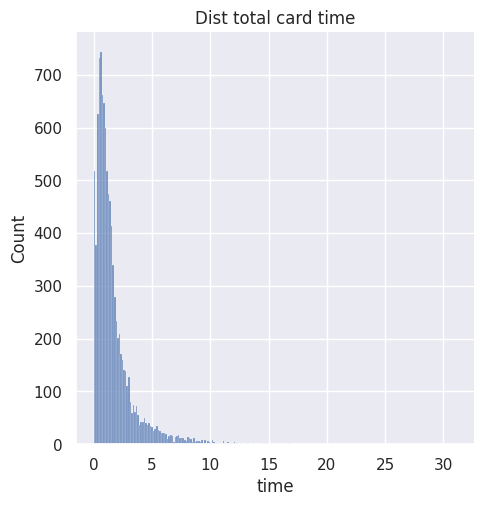

In [12]:

sns.displot(df[df.time < q].groupby('cid').agg('sum')/60000, x='time').set(title='Dist total card time') 

In [13]:
print(f"Total hrs on anki = {np.sum(df.time) / (60000 * 60)}")
print(f"Total hrs on anki removing 97% quantile = {np.sum(df[df.time < q].time) / (60000 * 60)}")

Total hrs on anki = 560.1797852777778
Total hrs on anki removing 97% quantile = 298.5370677777778


There's some cards creeping up into pretty large ranges. 

Looking at the distribution of reviews

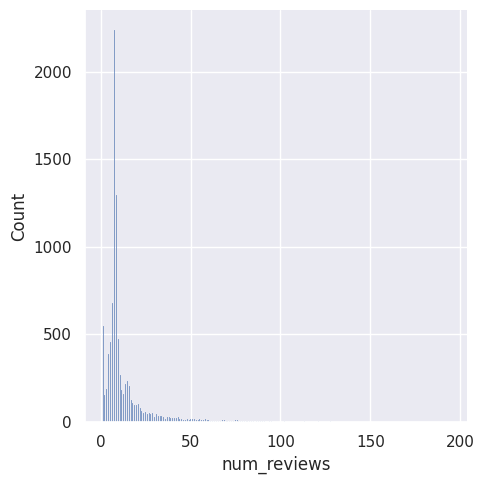

In [14]:
sns.displot(pd.DataFrame(data=df.groupby('cid').agg('size'), columns=['num_reviews']), x='num_reviews')

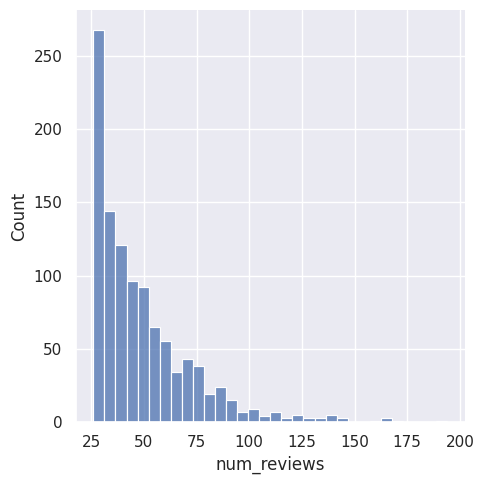

In [15]:
nr = pd.DataFrame(data=df.groupby('cid').agg('size'), columns=['num_reviews'])
nr.reset_index(inplace=True)
sns.displot(nr[nr.num_reviews > 25], x='num_reviews')

### Correlation between time and num_reviews

Look at the mean time of a card per review vs the number of reviews. Would expected there to be some relationship here such as:
- rushed cards have more reviews
- harder cards take longer to do and are not learned well

In [16]:
time = df.groupby('cid').agg('mean')/60000
time.reset_index(inplace=True)
nr['time'] = time.time
nr

,cid,num_reviews,time
0,1287867332874,2,0.107908
1,1287867617783,3,0.071883
2,1289966240018,5,0.088157
3,1321299135325,3,0.062422
4,1321299135326,3,0.026700
...,...,...,...
10263,1685598702394,3,0.127778
10264,1685598702400,3,0.061111
10265,1685599006378,3,0.527778
10266,1685599006389,5,1.566667


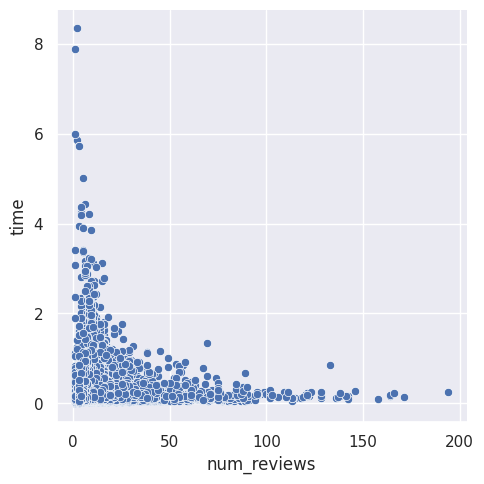

In [17]:
sns.relplot(data=nr, x="num_reviews", y="time")

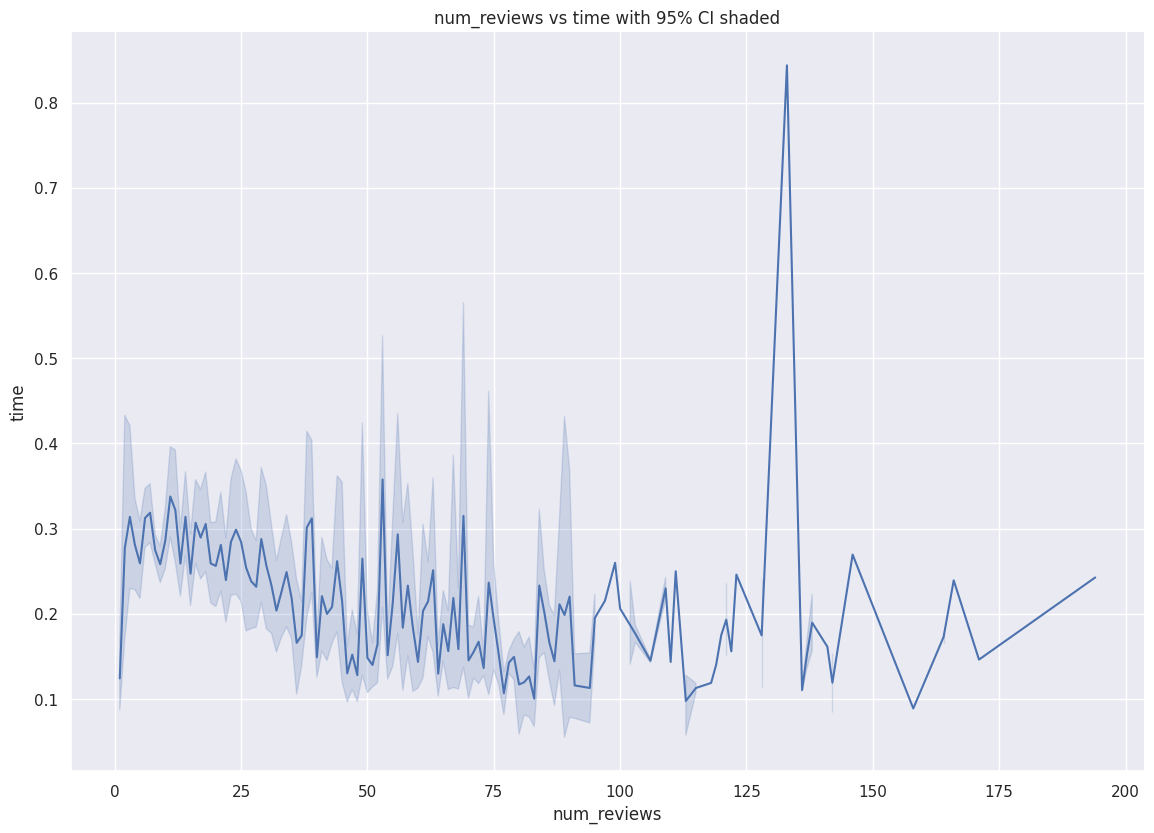

In [18]:
sns.relplot(data=nr, x="num_reviews", y="time", kind="line", height=8.27, aspect=11.7/8.27).set(title='num_reviews vs time with 95% CI shaded')

First note that anything passed ~100 reviews just doesn't have enough data. Seems to be a negative trend although variance is increasing. The confidence intervals are pretty large too, would be difficult to say much. 

# What does card progression look like. 

Say cards are reviewd as review0, review_1, review_2 ...

I want to construct a dataframe with entries:

[cid, review_n, time_diff(review_n - review_{n-1})]

In [51]:
data = [] # cid, review_n, time_diff
for cid, group in df.groupby("cid"):
    group = group.sort_values(by=['id'],ascending=True)
    for j,(i, row) in enumerate(group.diff().iterrows()):
        if j==0:
            continue
        
        data.append([cid, j, row['id']])
df_time_diff = pd.DataFrame(data=data, columns=['cid', 'nth_review', 'time_diff'])
df_time_diff['time_diff'] /= (60000 * 60 * 24)
df_time_diff

,cid,nth_review,time_diff
0,1287867332874,1,0.000768
1,1287867617783,1,0.000039
2,1287867617783,2,0.000021
3,1289966240018,1,8.089331
4,1289966240018,2,13.443271
...,...,...,...
123884,1685599006389,3,1.987998
123885,1685599006389,4,2.999525
123886,1685599006396,1,1.169769
123887,1685599006396,2,1.992118


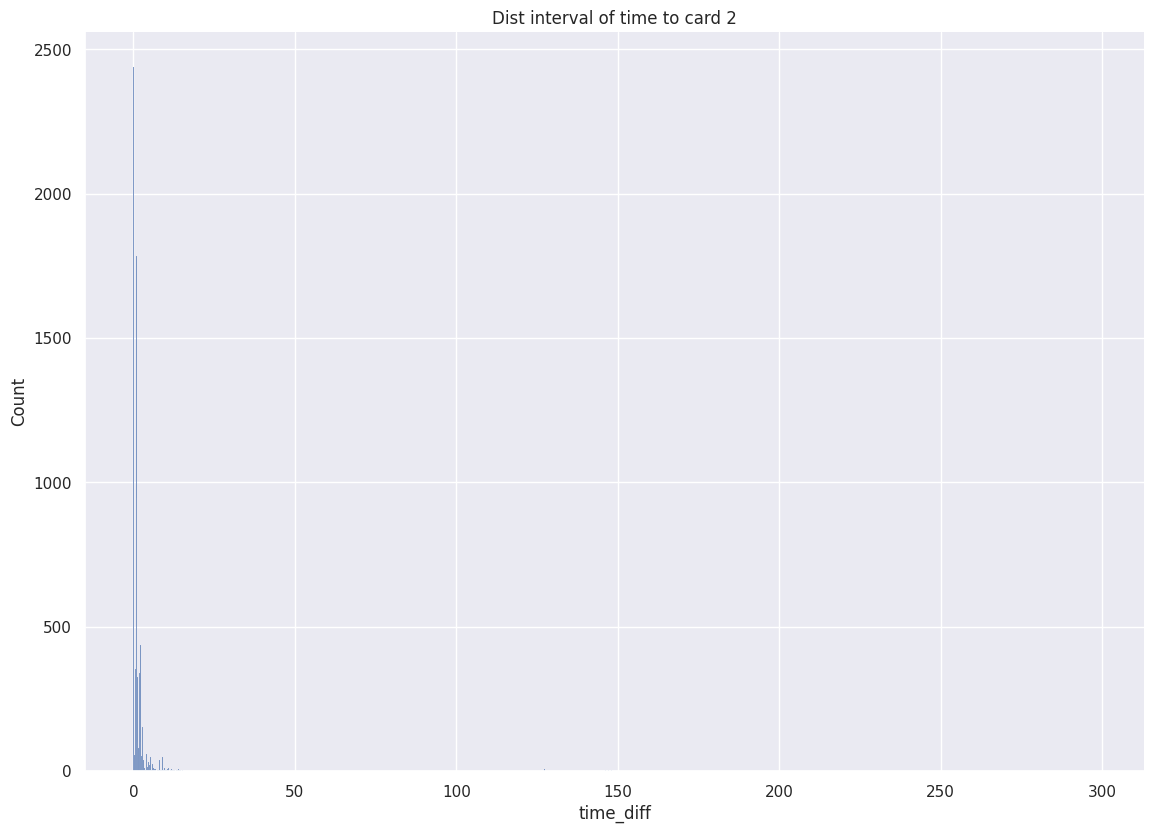

In [52]:
sns.displot(df_time_diff[(df_time_diff.nth_review == 2)], x='time_diff', height=8.27, aspect=11.7/8.27).set(title='Dist interval of time to card 2') 

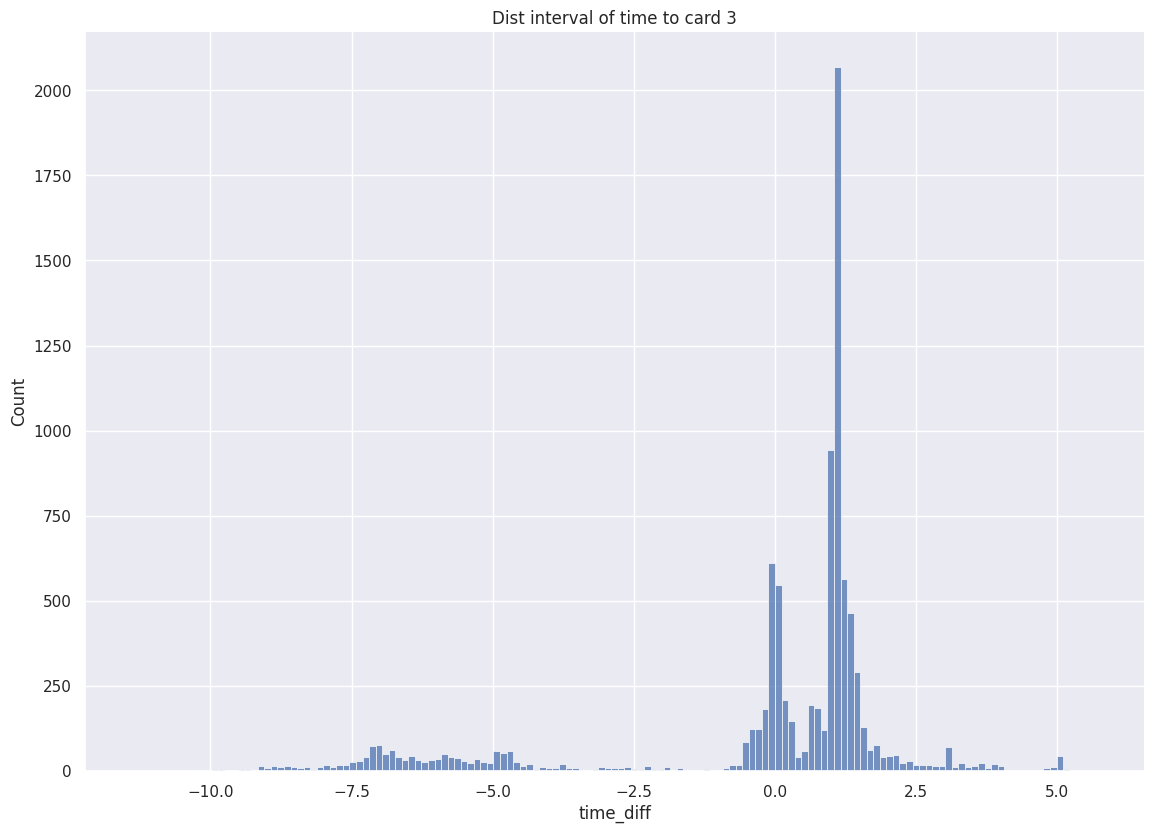

In [55]:
sns.displot(np.log(df_time_diff[(df_time_diff.nth_review == 3)]), x='time_diff', height=8.27, aspect=11.7/8.27).set(title='Dist interval of time to card 3') 

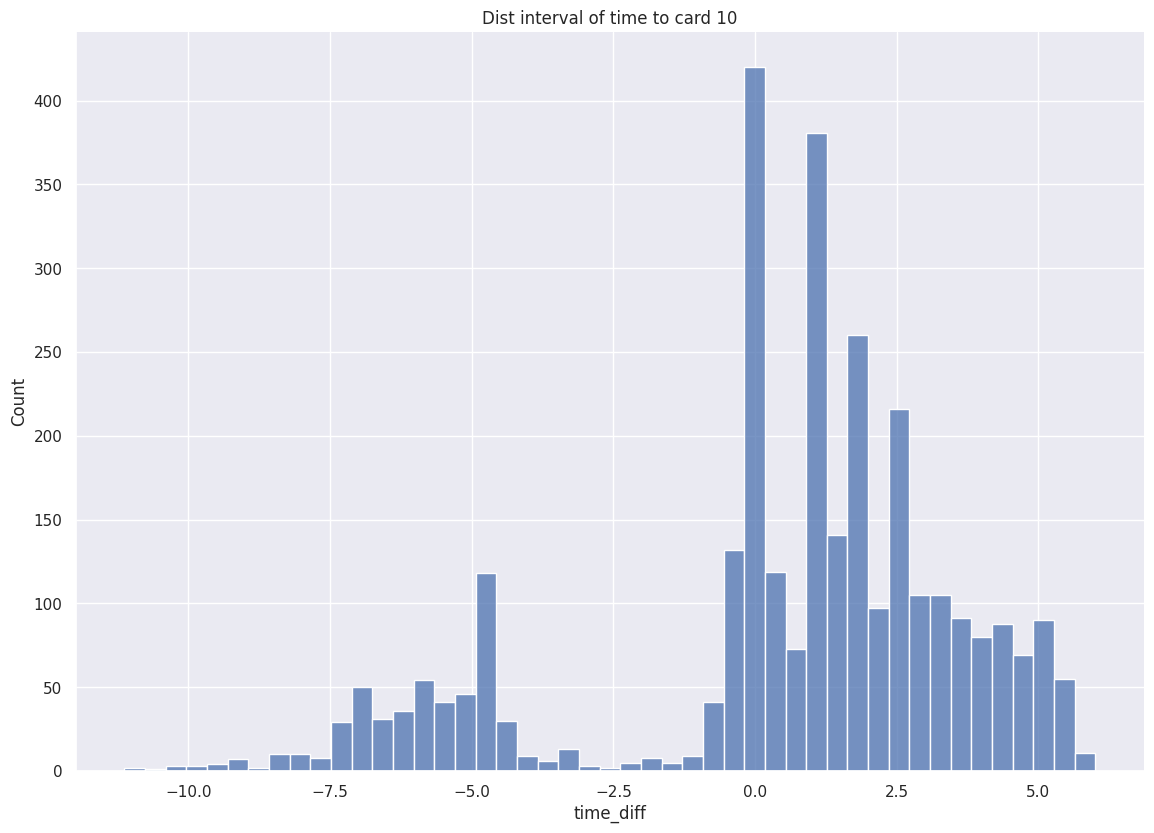

In [56]:
sns.displot(np.log(df_time_diff[(df_time_diff.nth_review == 10)]), x='time_diff', height=8.27, aspect=11.7/8.27).set(title='Dist interval of time to card 10') 